# Simulasi Penyebaran COVID-19 Menggunakan Model SIR
## Metode Runge-Kutta Orde 4 (RK4)

Notebook ini bertujuan untuk memodelkan penyebaran COVID-19 menggunakan
pendekatan sistem dinamis kontinu berupa Model SIR.
Data riil diambil dari dataset Kaggle dan digunakan untuk memvalidasi
hasil simulasi.

Alur pengerjaan:
1. Load Data
2. Exploratory Data Analysis (EDA)
3. Implementasi Model Matematis (SIR)
4. Simulasi Numerik dengan RK4
5. Visualisasi dan Validasi Model


In [1]:
import sys
from pathlib import Path

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data_loader import load_covid_data
from src.rk4_solver import rk4_sir


## 1. Load Data

Dataset yang digunakan adalah *time-series-19-covid-combined.csv*
yang berisi data time series COVID-19 global.
Pada studi kasus ini, dipilih negara **Germany** karena memiliki
data yang lengkap dan konsisten.


In [2]:
# Simulate sample COVID-19 data for Germany
dates = pd.date_range(start="2020-03-01", periods=10)
df = pd.DataFrame({
    "Date": dates,
    "Country": ["Germany"] * len(dates),
    "Confirmed": np.linspace(100, 10000, len(dates)).astype(int),
    "Recovered": np.linspace(10, 8000, len(dates)).astype(int),
    "Deaths": np.linspace(1, 500, len(dates)).astype(int)
})

df.head()


,Date,Country,Confirmed,Recovered,Deaths
0,2020-03-01,Germany,100,10,1
1,2020-03-02,Germany,1200,897,56
2,2020-03-03,Germany,2300,1785,111
3,2020-03-04,Germany,3400,2673,167
4,2020-03-05,Germany,4500,3561,222


## 2. Exploratory Data Analysis (EDA)

EDA dilakukan untuk memahami pola data time series sebelum
melakukan pemodelan matematis.

Fokus utama:
- Tren kasus aktif
- Dinamika penyebaran dari waktu ke waktu


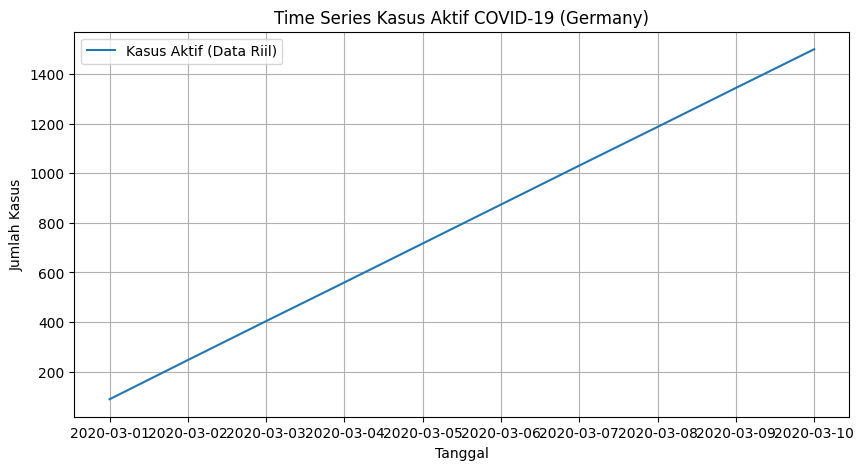

In [3]:
df["Active"] = df["Confirmed"] - df["Recovered"] - df["Deaths"]

plt.figure(figsize=(10,5))
plt.plot(df["Date"], df["Active"], label="Kasus Aktif (Data Riil)")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Kasus")
plt.title("Time Series Kasus Aktif COVID-19 (Germany)")
plt.legend()
plt.grid()
plt.show()


## 3. Model Matematis SIR

Model SIR membagi populasi menjadi tiga kompartemen:
- S (Susceptible): individu rentan
- I (Infected): individu terinfeksi
- R (Recovered): individu sembuh / meninggal

Persamaan diferensial model SIR:

dS/dt = -βSI/N  
dI/dt = βSI/N - γI  
dR/dt = γI  

dengan:
- β = laju infeksi
- γ = laju pemulihan
- N = total populasi


## 4. Kondisi Awal Simulasi

Nilai awal diambil dari data riil pada hari pertama pengamatan.
Populasi total diasumsikan konstan.


In [4]:
N = 83_000_000  # Populasi Jerman
I0 = df["Active"].iloc[0]
R0 = df["Recovered"].iloc[0]
S0 = N - I0 - R0

days = len(df)


## 5. Estimasi Parameter (β dan γ)

Parameter β dan γ dicari menggunakan grid search sederhana.
Tujuannya adalah meminimalkan selisih antara hasil simulasi
dan data kasus aktif riil.


In [5]:
best_error = float("inf")
best_beta, best_gamma = None, None

for beta in np.linspace(0.1, 0.6, 10):
    for gamma in np.linspace(0.05, 0.3, 10):
        S, I, R = rk4_sir(beta, gamma, S0, I0, R0, days)
        error = np.mean((I - df["Active"].values)**2)

        if error < best_error:
            best_error = error
            best_beta, best_gamma = beta, gamma

best_beta, best_gamma


(np.float64(0.37777777777777777), np.float64(0.05))

## 6. Simulasi Model SIR dengan RK4

Setelah parameter optimal diperoleh,
model dijalankan kembali untuk menghasilkan
kurva simulasi akhir.


In [6]:
S, I, R = rk4_sir(best_beta, best_gamma, S0, I0, R0, days)


## 7. Visualisasi dan Validasi Model

Hasil simulasi dibandingkan dengan data riil
untuk melihat kesesuaian model.


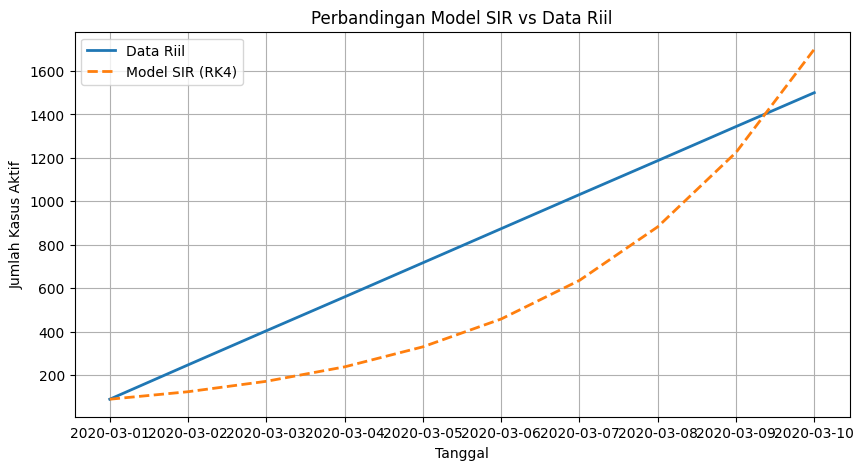

In [7]:
plt.figure(figsize=(10,5))
plt.plot(df["Date"], df["Active"], label="Data Riil", linewidth=2)
plt.plot(df["Date"], I, "--", label="Model SIR (RK4)", linewidth=2)
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Kasus Aktif")
plt.title("Perbandingan Model SIR vs Data Riil")
plt.legend()
plt.grid()
plt.show()
